In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

import json, os, sys
# sys.path.append("../utils")

plt.style.use("../../matplotlib_style/standard_plot_style.mplstyle")

figures_path = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/IQ_plane_initial"

data_path = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/experiments/trace_data/experiment_04_20.json"

In [2]:
with open(data_path) as file:
    data = json.load(file)

In [3]:
data.keys()

dict_keys(['network/qop_ip', 'network/port', 'controllers', 'digital_waveforms[]/name', 'digital_waveforms[]/samples', 'digital_waveforms[]_len', 'common_operation/name', 'common_operation/duration', 'common_operation/amplitude', 'readout_lines[]/length', 'readout_lines[]/lo_freq', 'readout_lines[]/lo_power', 'readout_lines[]/I_up/controller', 'readout_lines[]/I_up/channel', 'readout_lines[]/I_up/offset', 'readout_lines[]/Q_up/controller', 'readout_lines[]/Q_up/channel', 'readout_lines[]/Q_up/offset', 'readout_lines[]/I_down/controller', 'readout_lines[]/I_down/channel', 'readout_lines[]/I_down/offset', 'readout_lines[]/I_down/gain_db', 'readout_lines[]/Q_down/controller', 'readout_lines[]/Q_down/channel', 'readout_lines[]/Q_down/offset', 'readout_lines[]/Q_down/gain_db', 'readout_lines[]_len', 'readout_resonators[]/index', 'readout_resonators[]/name', 'readout_resonators[]/f_res', 'readout_resonators[]/f_opt', 'readout_resonators[]/readout_regime', 'readout_resonators[]/readout_amplit

In [4]:
ground_I_raw    = np.array(data["experiment_results"]["Readout signal (ground_state I) raw ss"]["value"])
ground_Q_raw    = np.array(data["experiment_results"]["Readout signal (ground_state Q) raw ss"]["value"])
excited_I_raw   = np.array(data["experiment_results"]["Readout signal (excited_state I) raw ss"]["value"])
excited_Q_raw   = np.array(data["experiment_results"]["Readout signal (excited_state Q) raw ss"]["value"])

In [5]:
# Subtract mean
ground_I_raw    = ground_I_raw - np.mean(ground_I_raw)
ground_Q_raw    = ground_Q_raw - np.mean(ground_Q_raw)
excited_I_raw   = excited_I_raw - np.mean(excited_I_raw)
excited_Q_raw   = excited_Q_raw - np.mean(excited_Q_raw)

In [6]:
ground_I_raw.shape

(1000, 5252)

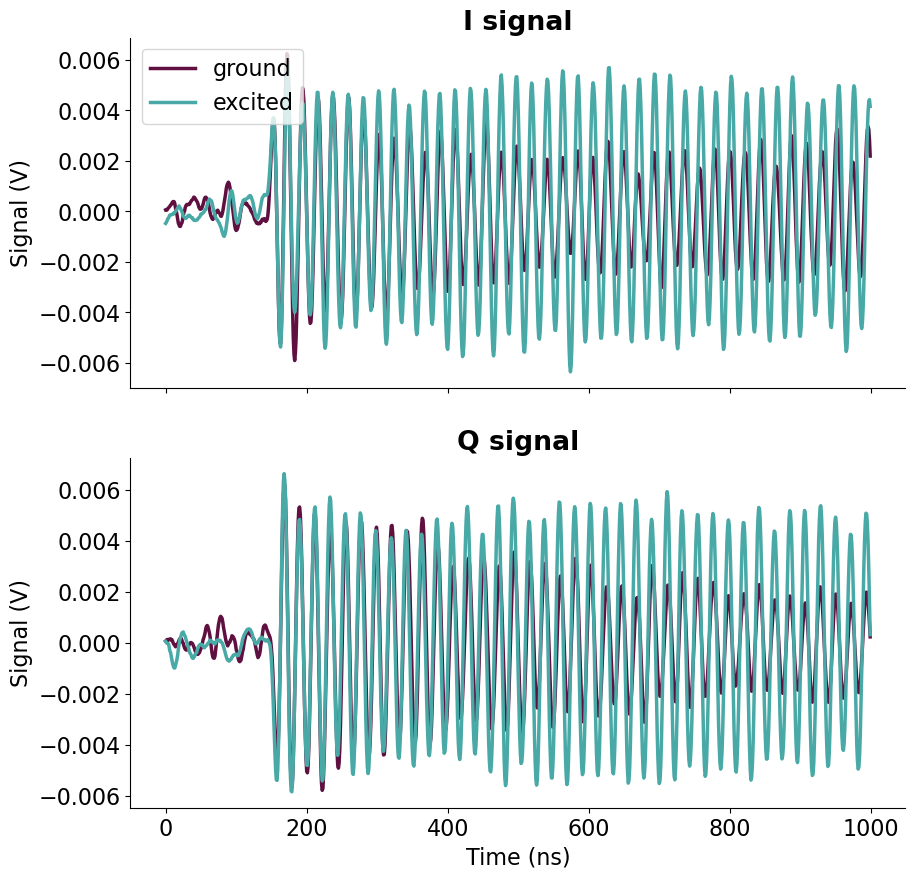

In [20]:
fig, (axI, axQ) = plt.subplots(nrows = 2, figsize = (10, 10), sharex = True)

axQ.plot(ground_Q_raw.mean(0)[:1000], label = "ground")
axI.plot(ground_I_raw.mean(0)[:1000], label = "ground")
axQ.plot(excited_Q_raw.mean(0)[:1000], label = "excited")
axI.plot(excited_I_raw.mean(0)[:1000], label = "excited")

axI.set(
    ylabel = "Signal (V)",
    title = "I signal"
)

axQ.set(
    xlabel = "Time (ns)",
    ylabel = "Signal (V)",
    title = "Q signal"
)

axI.legend(loc = "upper left")



In [8]:
driven_frequency = 7555991319.0 
local_oscillator_frequency = 7510000000

# Set frequency to work in nano seconds
intermediate_frequency = 1e-9 *  (driven_frequency - local_oscillator_frequency)


In [9]:
intermediate_frequency

0.045991319

The intermediate frequency is 0.045991319 GHz


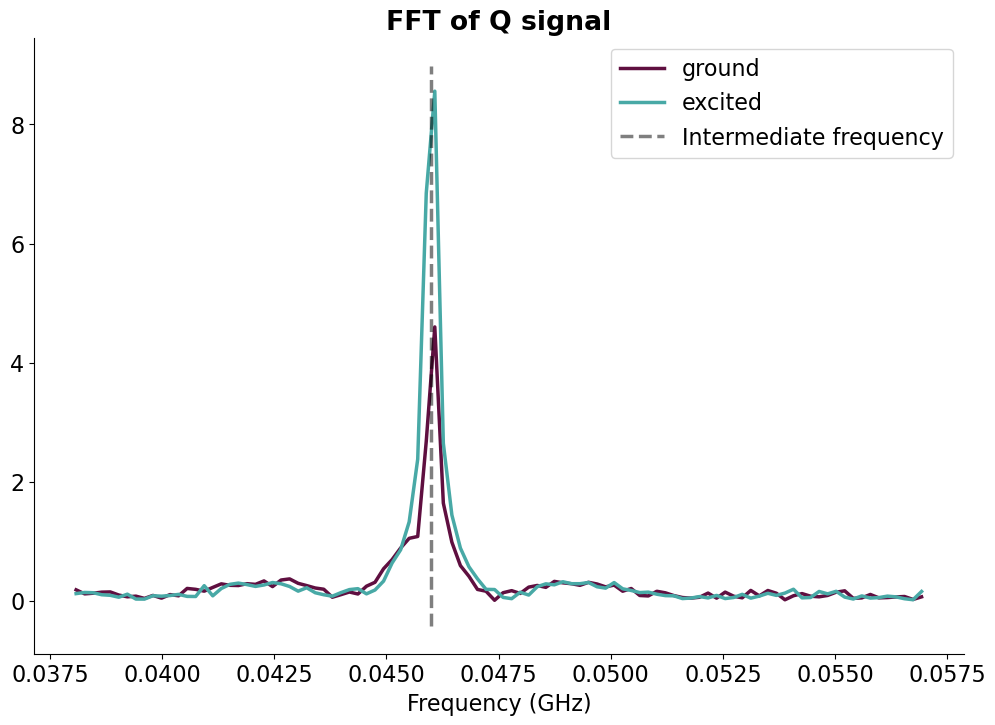

In [22]:
from numpy.fft import rfft, rfftfreq
plt.plot(rfftfreq(ground_Q_raw.shape[1], 1)[200:300], abs(rfft(ground_Q_raw.mean(0)))[200:300], label = "ground")
plt.plot(rfftfreq(ground_Q_raw.shape[1], 1)[200:300], abs(rfft(excited_Q_raw.mean(0)))[200:300], label = "excited")

plt.vlines(intermediate_frequency, *plt.gca().get_ylim(), color = "k", ls = "--", alpha = 0.5, label = "Intermediate frequency")
plt.xlabel("Frequency (GHz)")
plt.title("FFT of Q signal")
plt.legend()

print("The intermediate frequency is {} GHz".format(intermediate_frequency))

# Demodulation

In [11]:
z_ground_if  = ground_I_raw  + 1j*ground_Q_raw
z_excited_if = excited_I_raw + 1j*excited_Q_raw

In [12]:
demodulation = np.exp(1j * 2 * np.pi * intermediate_frequency * np.arange(ground_Q_raw.shape[1]))

In [13]:
z_ground_demod  = z_ground_if  * demodulation
z_excited_demod = z_excited_if * demodulation

I_ground = z_ground_demod.real
Q_ground = z_ground_demod.imag
I_excited = z_excited_demod.real
Q_excited = z_excited_demod.imag

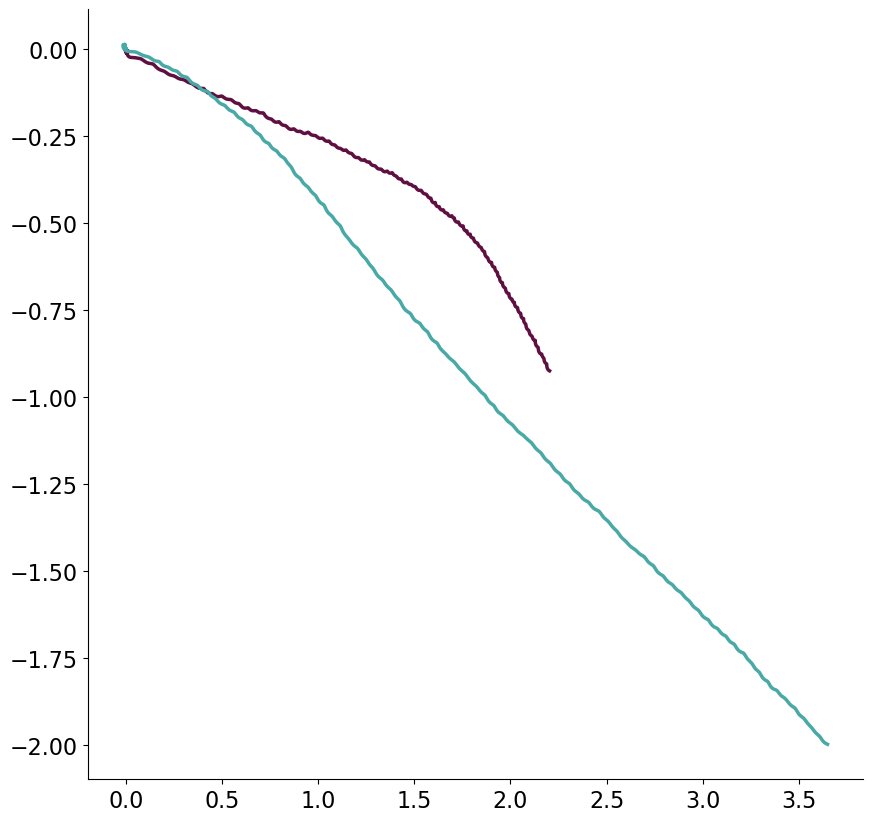

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.plot(I_ground.mean(0)[:1000].cumsum(), Q_ground.mean(0)[:1000].cumsum())
ax.plot(I_excited.mean(0)[:1000].cumsum(), Q_excited.mean(0)[:1000].cumsum())

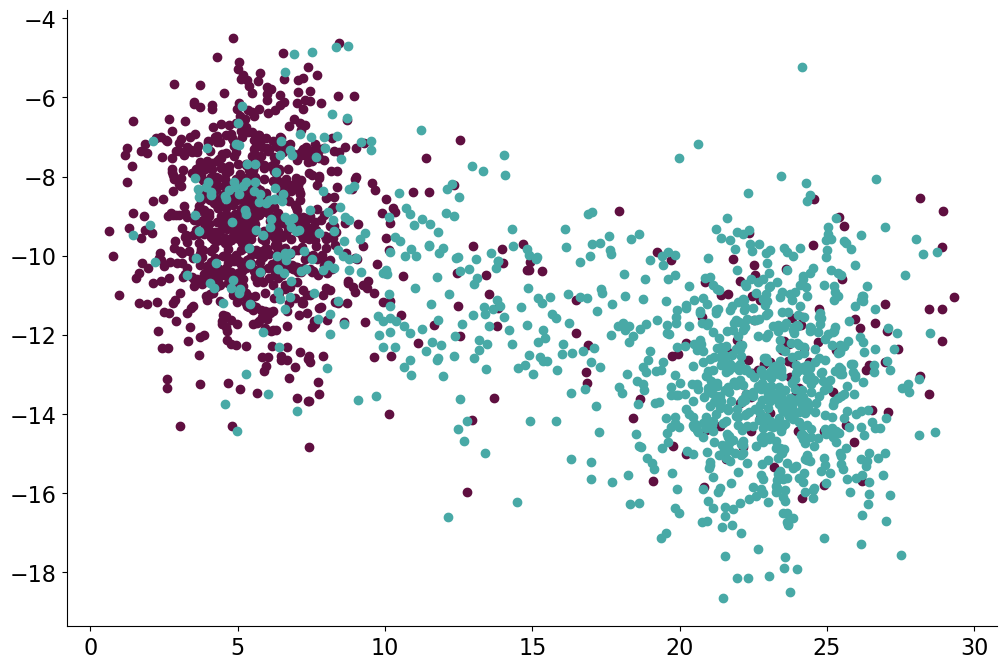

In [15]:
plt.scatter(I_ground.sum(1), Q_ground.sum(1), color = "C0")
plt.scatter(I_excited.sum(1), Q_excited.sum(1), color = "C1")

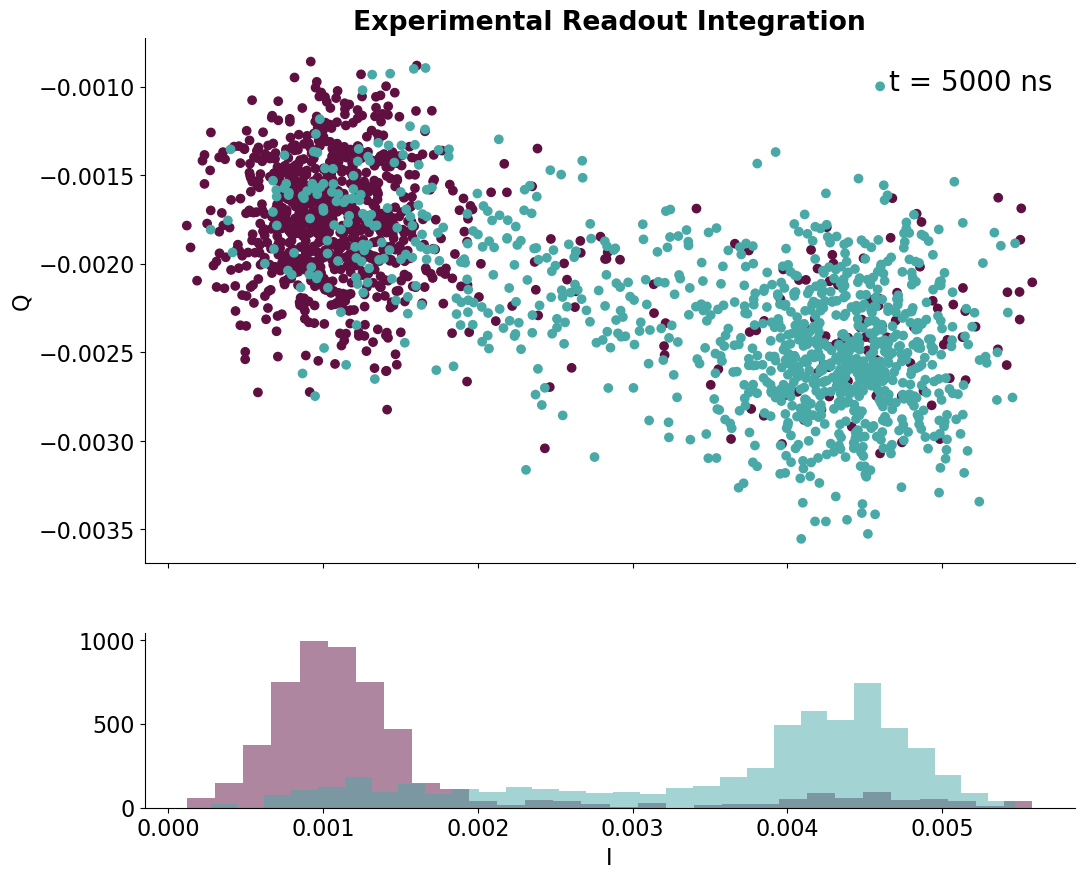

In [16]:
# The same but animated
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]}, sharex = True)

t = np.arange(ground_Q_raw.shape[1])

color = ["C0"] * I_ground.shape[0] + ["C1"] * I_excited.shape[0]

I_plot = np.concatenate([I_ground, I_excited], axis = 0)
Q_plot = np.concatenate([Q_ground, Q_excited], axis = 0)

scat_ground     = ax[0].scatter(I_plot.mean(1), Q_plot.mean(1), c = color)


ax[0].set(
    title = "Experimental Readout Integration",
    ylabel = "Q"
)
ax[1].set(
    xlabel = "I"
)

ax[0].text(0.8, 0.9, f"t = 5000 ns", transform = ax[0].transAxes, fontsize = 20)


ax[1].hist(I_ground.mean(1), bins = 30, alpha = 0.5, label = "0", density = True)
ax[1].hist(I_excited.mean(1), bins = 30, alpha = 0.5, label = "1", density = True);


def update(frame):
    ax[0].cla()
    ax[1].cla()

    ax[0].set(
        title = "Experimental Readout Integration",
        ylabel = "Q"
    )
    ax[1].set(
        xlabel = "I",
        ylabel = "Density"
    )

    ax[0].text(0.8, 0.8, f"t = {frame} ns", transform = ax[0].transAxes, fontsize = 20)

    ax[1].set_xlim(-0.003, 0.012)
    ax[0].set_ylim(-0.0080, 0.002)

    I_ground_at_t = I_ground[:, t < frame]
    Q_ground_at_t = Q_ground[:, t < frame]

    I_excited_at_t = I_excited[:, t < frame]
    Q_excited_at_t = Q_excited[:, t < frame]

    I_plot = np.concatenate([I_ground_at_t, I_excited_at_t], axis = 0)
    Q_plot = np.concatenate([Q_ground_at_t, Q_excited_at_t], axis = 0)


    scat_ground     = ax[0].scatter(I_plot.mean(1), Q_plot.mean(1), c = color)

    ax[1].hist(I_ground_at_t.mean(1), bins = 30, alpha = 0.5, label = "0", density = True)
    ax[1].hist(I_excited_at_t.mean(1), bins = 30, alpha = 0.5, label = "1", density = True);


In [17]:
from IPython.display import HTML 
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/readout_strategies"

if True:
    from matplotlib.animation import FuncAnimation
    anim = FuncAnimation(fig, update, frames = np.arange(100, 5250, 25), interval = 1000 / 30)
    anim.save(save_path + "/experimental_measuremernts.mp4", writer = "ffmpeg", fps = 30)
    display(HTML(anim.to_html5_video()))